In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pylab as plt
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

s = json.load(open("fbb_matplotlibrc.json"))
plt.rcParams.update(s)
%matplotlib inline

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def getCitiBikeCSV(datestring):
    
    print ("Downloading", datestring)
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))

            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            print("File in place, you can continue.")

            if '2014' in datestring or '2013' in datestring:
                    os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                              "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))

            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
                print("WARNING!!! something is wrong: the file is not there!")
    else:
        print("File in place, you can continue.")

In [3]:
data = pd.DataFrame()
for i in range(1, 13):
    if i < 10:
        datestring = '20150{0}'.format(i)
    else:
        datestring = '2015{0}'.format(i)
    getCitiBikeCSV(datestring)
    raw = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv').dropna()
    index = random.sample(range(len(raw)), int(len(raw)*0.01))
    raw_subset = raw.iloc[index, :]
    data = pd.concat([data, raw_subset])

File in place, you can continue.
File in place, you can continue.
File in place, you can continue.
File in place, you can continue.
File in place, you can continue.
File in place, you can continue.
File in place, you can continue.
File in place, you can continue.
File in place, you can continue.
File in place, you can continue.
File in place, you can continue.
File in place, you can continue.


In [4]:
data = data[["starttime", "gender"]]

In [5]:
data.starttime = pd.to_datetime(data.starttime)

dr = pd.date_range(start='2015-01-01', end='2015-12-31')
cal = calendar()
holidays = pd.DataFrame(cal.holidays(start=dr.min(), end=dr.max()))
data['holiday'] = data['starttime'].dt.date.isin(holidays[0].dt.date)

data.set_index("starttime", inplace = True)
data["Hours"] = data.index.hour
data["Hours"] = data["Hours"].astype(int)

In [6]:
data["WeekDay"] = data.index.weekday
data = data[(data["WeekDay"] != 5) & (data["WeekDay"] != 6) & (data["holiday"] == False)]

In [7]:
data.head()

,gender,holiday,Hours,WeekDay
starttime,,,,
2015-01-12 15:45:00,2,False,15,0
2015-01-23 23:31:00,1,False,23,4
2015-01-08 17:12:00,1,False,17,3
2015-01-15 09:03:00,1,False,9,3
2015-01-08 19:48:00,1,False,19,3


In [8]:
rush_hr = [7,8,9,16,17,18,19,20,21]
is_rushhr = lambda x: True if x in rush_hr else False

In [9]:
data.head()

,gender,holiday,Hours,WeekDay
starttime,,,,
2015-01-12 15:45:00,2,False,15,0
2015-01-23 23:31:00,1,False,23,4
2015-01-08 17:12:00,1,False,17,3
2015-01-15 09:03:00,1,False,9,3
2015-01-08 19:48:00,1,False,19,3


In [10]:
by_hours = pd.DataFrame({"Count": data.groupby("Hours").apply(len)})
by_hours.reset_index(level = 0, inplace = True)
by_hours["IsRushHr"] = by_hours["Hours"].apply(is_rushhr)
by_hours["IsRushHr"] = by_hours["IsRushHr"].astype("category")
by_hours.head()

,Hours,Count,IsRushHr
0,0,479,False
1,1,203,False
2,2,114,False
3,3,85,False
4,4,102,False


In [11]:
non_rush = by_hours["Count"][by_hours["IsRushHr"] == False]
rush = by_hours["Count"][by_hours["IsRushHr"] == True]

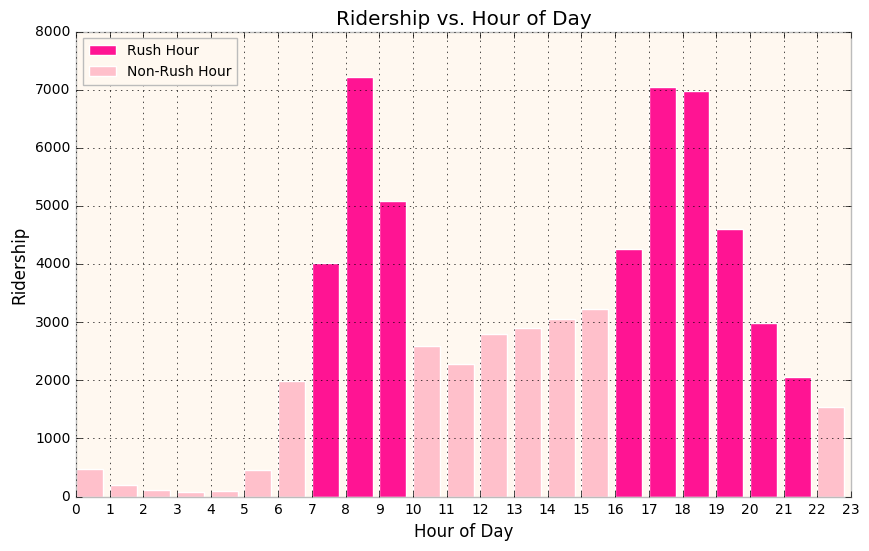

In [12]:
plt.figure(figsize = (10, 6))
plt.xlim(0,23); plt.ylim(0, 8000)
plt.xticks(np.arange(0,24))

plt.bar(by_hours.Hours[by_hours["IsRushHr"]==True], by_hours.Count[by_hours["IsRushHr"]==True],\
        color = '#FF1493', label = "Rush Hour")
plt.bar(by_hours.Hours[by_hours["IsRushHr"]==False], by_hours.Count[by_hours["IsRushHr"]==False],\
        color = '#FFC0CB', label = "Non-Rush Hour")

plt.ylabel("Ridership"); plt.xlabel("Hour of Day")
plt.title("Ridership vs. Hour of Day")

plt.legend(loc = 2)
plt.show()

In [13]:
stats.ttest_ind(rush, non_rush, equal_var = False)

Ttest_indResult(statistic=4.9010448123861732, pvalue=0.00034032385040634838)